## P300 decoding
Below is the decoding pipeline used for the P300 signal. The following preprocessing has already been done:
1. Channels are renamed from the BioSemi channels to the standard EEG channels.
2. The data is de-meaned to remove any baseline offset. This way the data is around zero and the signal start from a neutral point.
3. Events are detected.
4. Only relevant channels (Hubner set) are selected.
5. Bad channels are rejected.
6. Bandpass filter between 0.5 - 8 Hz is applied.
7. EEG data is re-referenced to the average of all channels.
8. Epochs are created from -1 until 21 seconds surrounding an event.
9. The data is resampled to a sampling frequency of 120 Hz.

### Results

In [1]:
import os
from os.path import join
import numpy as np
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.metrics import precision_recall_curve, auc
import warnings
warnings.filterwarnings("ignore")

derivatives_dir = '/Users/juliette/Desktop/thesis/p300_npz/preprocessed/p300'
decoding_results_dir = '/Users/juliette/Desktop/thesis/results/P300'

subjects = ["VPpdia","VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig","VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix","VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]


In [2]:
def balance_classes(X, y, ratio_0_to_1=1.0):
    
    """
    Sub-select X and y based on a specified ratio of 0s to 1s, keeping the original order.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n_samples, n_features).
    y (numpy.ndarray): Label vector of shape (n_samples,).
    ratio_0_to_1 (float): The desired ratio of 0s to 1s in the balanced dataset.

    Returns:
    X_balanced, y_balanced: Sub-selected feature matrix and label vector.
    """
    # Step 1: Identify indices of 0s and 1s
    indices_0 = np.where(y == 0)[0]
    indices_1 = np.where(y == 1)[0]
    
    # Step 2: Calculate the number of samples to select for each class
    num_1s = len(indices_1)
    num_0s = min(len(indices_0), int(num_1s * ratio_0_to_1))
    
    # Step 3: Randomly sample the desired number of 0s and 1s
    selected_indices_0 = np.random.choice(indices_0, num_0s, replace=False)
    selected_indices_1 = np.random.choice(indices_1, num_1s, replace=False)
    
    # Step 4: Combine selected indices and sort to preserve original order
    balanced_indices = np.sort(np.concatenate([selected_indices_0, selected_indices_1]))
    
    # Step 5: Sub-select X and y based on the balanced indices
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, y_balanced

def filter_valid_epochs(X, y, z=None, return_mask=False):
    """
    Filters out epochs where either the features in X or the labels in y contain NaN values.
    Optionally, if a z array is provided, it is filtered similarly.
    
    Parameters:
        X (np.ndarray): A 2D numpy array with shape (n_epochs, n_features).
        y (np.ndarray): A 1D numpy array with shape (n_epochs,).
        z (np.ndarray, optional): An array that will be filtered using the same mask.
        return_mask (bool, optional): If True, the boolean mask used for filtering is returned.
    
    Returns:
        filtered_X (np.ndarray): X with only rows that have no NaN values.
        filtered_y (np.ndarray): y with only entries corresponding to valid epochs.
        filtered_z (np.ndarray or None): Filtered z array (if provided) or None.
        mask (np.ndarray, optional): The boolean mask of valid epochs; only returned if return_mask=True.
    """
    # Create a mask for valid labels and features
    valid_label_mask = ~np.isnan(y)
    valid_feature_mask = ~np.isnan(X).any(axis=1)
    combined_mask = valid_label_mask & valid_feature_mask

    # Apply the mask to X and y
    filtered_X = X[combined_mask]
    filtered_y = y[combined_mask]
    
    if z is not None:
        filtered_z = z[combined_mask]
    else:
        filtered_z = None

    if return_mask:
        return filtered_X, filtered_y, filtered_z, combined_mask
    else:
        return filtered_X, filtered_y, filtered_z
    
    
#     start_idx= -120 + 60, end_idx= 2520 - 60

## Add epochs to data

In [3]:
def extract_epochs(X, start_idx=60, end_idx=2460, step_size=30, 
                   start_sample_offset=-24, end_sample_offset=84, 
                   amplitude_threshold=40e-6):
    """
    Function to extract epochs from time-series data for ERP features, 
    baseline-correct each epoch, and identify bad epochs based on amplitude threshold.
    
    Parameters:
    - X: Input data array of shape (n_trials, n_channels, n_samples)
    - start_idx: The starting sample index for the first epoch (default=120)
    - end_idx: The last sample index where the final epoch starts (default=2520)
    - step_size: Step size in samples, corresponding to the sliding window (default=30)
    - start_sample_offset: The offset for the start of the time window (default=-24, corresponds to -200 ms)
    - end_sample_offset: The offset for the end of the time window (default=84, corresponds to 700 ms)
    - amplitude_threshold: Threshold for identifying bad epochs based on amplitude range (default=100)
    
    Returns:
    - output_matrix: A 4D array of extracted and baseline-corrected epochs of shape 
                     (n_trials, n_epochs, n_channels, window_size)
    - bad_epochs_idx: List of indices of bad epochs for each trial and channel 
                      where amplitude range exceeds the threshold.
    """
    # Check input dimensions
    if X.ndim != 3:
        raise ValueError(f"Input X must have 3 dimensions (n_trials, n_channels, n_samples), but got {X.ndim} dimensions.")
    
    n_trials, n_channels, n_samples = X.shape
    window_size = end_sample_offset + np.abs(start_sample_offset)  # 108 samples
    epoch_timestamps = np.arange(start_idx, end_idx, step_size)    # (80,)
    n_epochs = len(epoch_timestamps)
    
    # Initialize the output matrix for the epochs and a list for bad epoch indices
    output_matrix = np.zeros((n_trials, n_epochs, n_channels, window_size))
    bad_epochs_idx = []  # To store (trial, epoch, channel) indices of bad epochs
    
    # Loop over trials, channels, and epochs to extract and baseline-correct the windows
    for i_trial in range(n_trials):
        for i_channel in range(n_channels):
            data = X[i_trial, i_channel, :]

            for i_epoch, t in enumerate(epoch_timestamps):
                epoch_start_idx = t + start_sample_offset  # Start at t - 24 samples (-200 ms)
                epoch_end_idx = t + end_sample_offset      # End at t + 84 samples (700 ms)
                
                # Ensure the window stays within bounds
                if epoch_start_idx >= 0 and epoch_end_idx <= n_samples:
                    epoch_data = data[epoch_start_idx:epoch_end_idx]
                    
                    # Baseline correction
                    baseline_mean = np.mean(epoch_data[:25])
                    epoch_data = epoch_data - baseline_mean
                    
                    # Store the epoch in the output matrix
                    output_matrix[i_trial, i_epoch, i_channel, :] = epoch_data
                    
                    # Check amplitude range after baseline subtraction
                    min_amp, max_amp = np.min(epoch_data), np.max(epoch_data)
                    amplitude_range = max_amp - min_amp
                    
                    # Log bad epochs if amplitude range exceeds threshold
                    if amplitude_range > amplitude_threshold:
                        bad_epochs_idx.append((i_trial, i_epoch, i_channel))
    
    # Return the 4D output matrix and the indices of bad epochs
    return output_matrix, bad_epochs_idx


In [4]:
def extract_features_from_X(X_matrix, ToI = None):
    """
    Extracts the maximum amplitudes from specified time ranges for each trial, epoch, and channel in the input data.

    Parameters:
    - X_matrix: A 4D numpy array of shape (n_trials, n_epochs, n_channels, n_samples) representing the input data.
    - ToI: A list of tuples, where each tuple contains the start and end indices of a time range of interest.

    Returns:
    - feature_matrix: A 4D numpy array of shape (n_trials, n_epochs, n_channels, len(ToI)) containing the maximum
                      values from the specified time ranges for each trial, epoch, and channel.
    """
    # Extract the shape of the input matrix
    n_trials, n_epochs, n_channels, n_samples = X_matrix.shape 
    
    # Initialize the feature matrix to store maximum values for each time range
    feature_matrix = np.zeros((n_trials, n_epochs, n_channels, len(ToI)))

    # Loop over the time ranges (ToI) and extract the max value for each range
    for i_range, (start, end) in enumerate(ToI):
        # For each time range, find the maximum values along the last axis (time samples) in the specified range
        feature_matrix[ :, :, :, i_range] = np.mean((X_matrix[ :, :, :, start:end]), axis=-1)

    # Return the feature matrix
    return feature_matrix

In [5]:
def mark_bad_epochs(X, z, bad_idx):
    """
    Marks bad epochs in both EEG data (X) and labels (z) by setting them to NaN (or another sentinel, ie -1).

    Parameters
    ----------
    X : ndarray
        4D array of shape (n_trials, n_epochs, n_channels, n_timepoints).
    z : ndarray
        3D array of shape (n_trials, n_epochs, label_dim).
    bad_idx : list of tuples
        List of (trial, epoch, channel) indices indicating bad epochs.

    Returns
    -------
    X_marked : ndarray
        Same shape as X, with bad epochs set to NaN (or a chosen sentinel).
    z_marked : ndarray
        Same shape as z, with bad epochs set to NaN (or a chosen sentinel).
    """
    # Convert list of (trial, epoch, channel) to a set of (trial, epoch) pairs
    bad_trial_epoch_pairs = set((trial, epoch) for trial, epoch, _ in bad_idx)

    # Make copies so we don't overwrite the original arrays
    X_marked = np.copy(X)
    z_marked = np.copy(z).astype(np.float64)

    # Mark each bad epoch in both X and z
    for trial_idx, epoch_idx in bad_trial_epoch_pairs:
        X_marked[trial_idx, epoch_idx, :, :] = np.nan 
        z_marked[trial_idx, epoch_idx, :]    = np.nan 

    return X_marked, z_marked

# Without ICA

In [7]:
rejection_threshold = 1
task = "covert"  

derivatives_dir = '/Users/juliette/Desktop/thesis/preprocessing'

for subject in subjects:
    print("subject:", subject)
    
    # Load the NPZ file
    file_dir = os.path.join(derivatives_dir, "p300_preprocessing")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_p300.npz") 

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    npz_data = np.load(file_path)

    # Extract data from the npz object
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels indicating cued side: trials
    z = npz_data['z']  # Left and right targets: trials x epochs x sides
    fs = npz_data['fs']  # Sampling frequency
    print("fs:", fs)

    X_matrix, bad_idx = extract_epochs(X, amplitude_threshold=rejection_threshold)
    '''
    Tag bad epochs by setting the values of above-threshold values to NaN
    Either use marking like this or alternatively remove it at this stage. Key to retain trial structure!!
    Inhomogenity in epoch-dimension size lead to error when constructing np-based matrix, cannot flatten trials & epoch dimenstions as this discards trial strcture 
    Alternative solution: Build list of arrays and save individually. Decoding needs to be adapted for this data structure.
    '''
    print("X_matrix.shape:", X_matrix.shape)
    X_matrix, z = mark_bad_epochs(X_matrix, z, bad_idx)
    
    # Define periods for feature extraction
    ToI = [(30, 38), (38, 48), (48, 57), (57, 69), (69, 87), (87, 108)]

    feature_matrix = extract_features_from_X(X_matrix, ToI)
    print(feature_matrix.shape)

    # Save in one NPZ object
    save_dir = os.path.join(derivatives_dir, "features", "p300", f"sub-{subject}")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # ..features_noreject.npz
    # ..features.npz
    np.savez(os.path.join(save_dir, f"sub-{subject}_task-{task}_p300_features.npz"), X=feature_matrix, y=y, z=z, fs=fs)

subject: VPpdia
fs: 120
X_matrix.shape: (80, 80, 62, 108)
(80, 80, 62, 6)
subject: VPpdib
fs: 120
X_matrix.shape: (80, 80, 61, 108)
(80, 80, 61, 6)
subject: VPpdic
fs: 120
X_matrix.shape: (80, 80, 63, 108)
(80, 80, 63, 6)
subject: VPpdid
fs: 120
X_matrix.shape: (80, 80, 63, 108)
(80, 80, 63, 6)
subject: VPpdie
fs: 120
X_matrix.shape: (80, 80, 63, 108)
(80, 80, 63, 6)
subject: VPpdif
fs: 120
X_matrix.shape: (80, 80, 62, 108)
(80, 80, 62, 6)
subject: VPpdig
fs: 120
X_matrix.shape: (80, 80, 63, 108)
(80, 80, 63, 6)
subject: VPpdih
fs: 120
X_matrix.shape: (80, 80, 62, 108)
(80, 80, 62, 6)
subject: VPpdii
fs: 120
X_matrix.shape: (80, 80, 63, 108)
(80, 80, 63, 6)
subject: VPpdij
fs: 120
X_matrix.shape: (80, 80, 62, 108)
(80, 80, 62, 6)
subject: VPpdik
fs: 120
X_matrix.shape: (80, 80, 63, 108)
(80, 80, 63, 6)
subject: VPpdil
fs: 120
X_matrix.shape: (80, 80, 63, 108)
(80, 80, 63, 6)
subject: VPpdim
fs: 120
X_matrix.shape: (80, 80, 64, 108)
(80, 80, 64, 6)
subject: VPpdin
fs: 120
X_matrix.shape

## Decoding pipeline

In [8]:
# -- Parameters -- 
discard_threshold = 20
do_balance_classes = True
ratio_0_to_1 = 5
# load .._p300_features for NaN-marked feature matrix
# and .._p300_features_noreject for non-marked feature matrix

discarded_trials = []
results_decoding = {"subjects": []}
task = 'covert'
for subject in subjects:
    print("Subject:", subject)
    file_path = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/features/p300', f"sub-{subject}", 
                            f"sub-{subject}_task-{task}_p300_features.npz")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

     # Load the data from the NPZ file
    npz_data = np.load(file_path)
    # Extract data
    X = npz_data['X']  # EEG data: trials x epochs x channels x features
    y = npz_data['y']  # Labels indicating cued side: trials
    z = npz_data['z']  # Left and right targets: trials x epochs x sides
    print("Shape X:", X.shape)
    print("Shape of x:", z.shape)
    
    # Cross-validation setup
    n_folds = 4
    n_trials = int(X.shape[0] / n_folds)
    folds = np.repeat(np.arange(n_folds), n_trials)

    fold_pr_auc = []
    fold_correct_trials = []

    # Cross-validation loop alike in pyntbci
    discarded_trial_counter = 0
    for i_fold in range(n_folds):
    # Split into train and test sets
        X_trn_trials, y_trn_trials, z_trn_trials = X[folds != i_fold], y[folds != i_fold], z[folds != i_fold]
        X_tst_trials, y_tst_trials, z_tst_trials = X[folds == i_fold], y[folds == i_fold], z[folds == i_fold]
        
        ### TRAINING
        # Flatten training trials into epochs: shape becomes [n_trials * epochs, channel * features]
        X_trn_epochs = X_trn_trials.reshape(-1, X_trn_trials.shape[2] * X_trn_trials.shape[3])
        
        # Extract labels for training epochs using z and y 
        trial_indices_trn = np.arange(len(y_trn_trials))  # indices for trials
        y_trn_epochs = z_trn_trials[trial_indices_trn, :, y_trn_trials].reshape(-1)
        
        print("X_trn_epochs.shape", X_trn_epochs.shape)
        # Filter training epochs
        X_trn_epochs, y_trn_epochs, _ = filter_valid_epochs(X_trn_epochs, y_trn_epochs)
        
        # Balance training classes
        if do_balance_classes:
            X_trn_epochs, y_trn_epochs = balance_classes(X_trn_epochs, y_trn_epochs, ratio_0_to_1=ratio_0_to_1)
        
        # Sanity check for training data
        if np.isnan(X_trn_epochs).any() or np.isnan(y_trn_epochs).any():
            raise ValueError("NaNs found in training epochs after filtering!")
        
        ## Fit LDA
        lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())
        # Dimensionality bust be 2
        lda.fit(X_trn_epochs, y_trn_epochs)

        ### TESTING
        # Flatten testing trials into epochs
        X_tst_epochs = X_tst_trials.reshape(-1, X_tst_trials.shape[2] * X_tst_trials.shape[3])
        
        # Extract labels for testing epochs (again, using z and y for indexing)
        trial_indices_tst = np.arange(len(y_tst_trials))
        y_tst_epochs = z_tst_trials[trial_indices_tst, :, y_tst_trials].reshape(-1)
        
        # Reshape z_tst_trials into epochs.
        z_tst_epochs = z_tst_trials.reshape(len(y_tst_trials) * z_tst_trials.shape[1], 2)
        
        # Filter testing epochs and also retrieve the original mask so we can count epochs per trial
        X_tst_epochs, y_tst_epochs, z_tst_epochs, combined_mask_tst = filter_valid_epochs(
            X_tst_epochs, y_tst_epochs, z=z_tst_epochs, return_mask=True
        )
        
        # Calculate the number of preserved epochs per trial for testing.
        # Here, combined_mask_tst still has the original shape before filtering.
        # Reshape it to [n_trials, epochs_per_trial] and sum True values per trial.
        epoch_counts = combined_mask_tst.reshape(len(y_tst_trials), -1)
        num_epochs = np.sum(epoch_counts, axis=1)
        
        # Rebuild trial structure for testing data based on num_epochs
        nested_X_tst_trials = []
        nested_z_tst_epochs = []
        start_idx = 0
        for trial_idx, n_ep in enumerate(num_epochs):
            end_idx = start_idx + n_ep
            nested_X_tst_trials.append(X_tst_epochs[start_idx:end_idx])
            nested_z_tst_epochs.append(z_tst_epochs[start_idx:end_idx])
            start_idx = end_idx
        

        # Evaluate model on test data
        correct_trials = 0
        
        for t_idx in range(len(y_tst_trials)):

            num_preserved_epochs = num_epochs[t_idx]
            if num_preserved_epochs < discard_threshold:
                discarded_trial_counter +=1
                continue
            
            # Log cued side informed by y_tst
            cued_side = y_tst_trials[t_idx]
            # create event vectors & ground truth
            left_targets = nested_z_tst_epochs[t_idx][:, 0]
            right_targets = nested_z_tst_epochs[t_idx][:, 1]
            cued_targets = nested_z_tst_epochs[t_idx] [:, cued_side]
            
   
            # Compute LDA scores for epochs
            epoch_scores = lda.decision_function(nested_X_tst_trials[t_idx])
            
            # Log performance per fold
            precision, recall, _ = precision_recall_curve(cued_targets, epoch_scores)
            pr_auc_score = auc(recall, precision)
            fold_pr_auc.append(pr_auc_score)

            # Correlation-based decision
            corr_left, _ = pearsonr(epoch_scores, left_targets)
            corr_right, _ = pearsonr(epoch_scores, right_targets)

            # Trial-level decision rule based on correlation
            decision = 0 if corr_left > corr_right else 1
            if decision == cued_side:
                correct_trials += 1
        
        fold_correct_trials.append(correct_trials)
    discarded_trials.append([subject, discarded_trial_counter/ n_folds])
    # Compute perf metrics
    pr_auc_mean = np.mean(fold_pr_auc)
    pr_auc_se = np.std(fold_pr_auc, ddof=1) / np.sqrt(len(fold_pr_auc))
    correct_trials_mean = np.mean(fold_correct_trials) / (y.size / n_folds)
    correct_trials_se = np.std(fold_correct_trials, ddof=1) / np.sqrt(len(fold_correct_trials)) / (y.size / n_folds)
     
     # --- Prepare Data for saving ---
    # Store results
    results_decoding["subjects"].append({
        "subject_id": subject,
        "pr_auc_mean": pr_auc_mean,
        "pr_auc_se": pr_auc_se,
        "correct_trials_mean": correct_trials_mean,
        "correct_trials_se": correct_trials_se
    })
    # --- Add Aggregate (Overall) Results Before Saving ---
pr_auc_means = [subj['pr_auc_mean'] for subj in results_decoding["subjects"]]
correct_trials_means = [subj['correct_trials_mean'] for subj in results_decoding["subjects"]]

overall_result = {
    "subject_id": "Overall",
    "pr_auc_mean": np.mean(pr_auc_means),
    "pr_auc_se": np.std(pr_auc_means, ddof=1) / np.sqrt(len(pr_auc_means)),
    "correct_trials_mean": np.mean(correct_trials_means),
    "correct_trials_se": np.std(correct_trials_means, ddof=1) / np.sqrt(len(correct_trials_means))
}
results_decoding["subjects"].append(overall_result)

# Convert results to a structured NumPy array for saving
dtype = [
    ('subject_id', 'U10'),   # Unicode string (max length 10)
    ('pr_auc_mean', 'f8'),
    ('pr_auc_se', 'f8'),
    ('correct_trials_mean', 'f8'),
    ('correct_trials_se', 'f8')
]
structured_array = np.array(
    [
        (
            subj['subject_id'],
            subj['pr_auc_mean'],
            subj['pr_auc_se'],
            subj['correct_trials_mean'],
            subj['correct_trials_se']
        )
        for subj in results_decoding['subjects']
    ],
    dtype=dtype
)

# Save the structured array
if not os.path.exists(decoding_results_dir):
    os.makedirs(decoding_results_dir)
np.save(join(decoding_results_dir, f"{task}_lda_p300_results.npy"), structured_array)

# --- Print Overall Metrics ---
overall_pr_auc_mean = overall_result['pr_auc_mean']
overall_pr_auc_se = overall_result['pr_auc_se']
overall_accuracy_mean = overall_result['correct_trials_mean']
overall_accuracy_se = overall_result['correct_trials_se']

print(f"Overall LDA PR-AUC: {overall_pr_auc_mean:.2f} ± {overall_pr_auc_se:.2f}")
print(f"Overall trial level inference accuracy: {overall_accuracy_mean:.2f} ± {overall_accuracy_se:.2f}")

# --- Log Discarded Trials ---

discarded_trials_log = [(subj, val) for subj, val in discarded_trials if val > (1 / 4)] # account for fold-average
if discarded_trials_log:
    print(f"Trials discarded (< {discard_threshold} epochs available for integration) for the following subjects (fold-average):")
    for subj, val in discarded_trials_log:
        print(f"Subject: {subj}, Discarded Trials: {val}")
else:
    print("No trials discarded.")

Subject: VPpdia
Shape X: (80, 80, 62, 6)
Shape of x: (80, 80, 2)
X_trn_epochs.shape (4800, 372)
X_trn_epochs.shape (4800, 372)
X_trn_epochs.shape (4800, 372)
X_trn_epochs.shape (4800, 372)
Subject: VPpdib
Shape X: (80, 80, 61, 6)
Shape of x: (80, 80, 2)
X_trn_epochs.shape (4800, 366)
X_trn_epochs.shape (4800, 366)
X_trn_epochs.shape (4800, 366)
X_trn_epochs.shape (4800, 366)
Subject: VPpdic
Shape X: (80, 80, 63, 6)
Shape of x: (80, 80, 2)
X_trn_epochs.shape (4800, 378)
X_trn_epochs.shape (4800, 378)
X_trn_epochs.shape (4800, 378)
X_trn_epochs.shape (4800, 378)
Subject: VPpdid
Shape X: (80, 80, 63, 6)
Shape of x: (80, 80, 2)
X_trn_epochs.shape (4800, 378)
X_trn_epochs.shape (4800, 378)
X_trn_epochs.shape (4800, 378)
X_trn_epochs.shape (4800, 378)
Subject: VPpdie
Shape X: (80, 80, 63, 6)
Shape of x: (80, 80, 2)
X_trn_epochs.shape (4800, 378)
X_trn_epochs.shape (4800, 378)
X_trn_epochs.shape (4800, 378)
X_trn_epochs.shape (4800, 378)
Subject: VPpdif
Shape X: (80, 80, 62, 6)
Shape of x: (8

# With ICA

In [6]:
rejection_threshold = 1
task = "covert"  
subjects = ["VPpdia","VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig","VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix","VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]

derivatives_dir = '/Users/juliette/Desktop/thesis/preprocessing/p300_preprocessing/p300_ICA'
save = '/Users/juliette/Desktop/thesis/preprocessing/features/with_ICA'

for subject in subjects:
    print("subject:", subject)
    
    # Load the NPZ file
    file_path = os.path.join(derivatives_dir, f"sub-{subject}_task-{task}_p300_ICA.npz") 

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    npz_data = np.load(file_path)

    # Extract data from the npz object
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels indicating cued side: trials
    z = npz_data['z']  # Left and right targets: trials x epochs x sides
    fs = npz_data['fs']  # Sampling frequency

    X_matrix, bad_idx = extract_epochs(X, amplitude_threshold=rejection_threshold)
    '''
    Tag bad epochs by setting the values of above-threshold values to NaN
    Either use marking like this or alternatively remove it at this stage. Key to retain trial structure!!
    Inhomogenity in epoch-dimension size lead to error when constructing np-based matrix, cannot flatten trials & epoch dimenstions as this discards trial strcture 
    Alternative solution: Build list of arrays and save individually. Decoding needs to be adapted for this data structure.
    '''
    X_matrix, z = mark_bad_epochs(X_matrix, z, bad_idx)
    
    # Define periods for feature extraction
    ToI = [(30, 38), (38, 48), (48, 57), (57, 69), (69, 87), (87, 108)]

    feature_matrix = extract_features_from_X(X_matrix, ToI)

    # Save in one NPZ object
    save_dir = os.path.join(save, f"sub-{subject}")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # ..features_noreject.npz
    # ..features.npz
    print("feature_matrix:", feature_matrix.shape)
    np.savez(os.path.join(save_dir, f"sub-{subject}_task-{task}_p300_features_ICA.npz"), X=feature_matrix, y=y, z=z, fs=fs)

subject: VPpdia


KeyboardInterrupt: 

In [10]:
# -- Parameters -- 
discard_threshold = 20
do_balance_classes = False
ratio_0_to_1 = 5

decoding_results_dir = '/Users/juliette/Desktop/thesis/results/P300/p300_ICA'

discarded_trials = []
results_decoding = {"subjects": []}
task = 'covert'
for subject in subjects:
    print("subject:", subject)
    file_path = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/features/with_ICA', f"sub-{subject}", 
                            f"sub-{subject}_task-{task}_p300_features_ICA.npz")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

     # Load the data from the NPZ file
    npz_data = np.load(file_path)
    # Extract data
    X = npz_data['X']  # EEG data: trials x epochs x channels x features
    y = npz_data['y']  # Labels indicating cued side: trials
    z = npz_data['z']  # Left and right targets: trials x epochs x sides
    
    # Cross-validation setup
    n_folds = 4
    n_trials = int(X.shape[0] / n_folds)
    folds = np.repeat(np.arange(n_folds), n_trials)

    fold_pr_auc = []
    fold_correct_trials = []

    # Cross-validation loop alike in pyntbci
    discarded_trial_counter = 0
    for i_fold in range(n_folds):
    # Split into train and test sets
        X_trn_trials, y_trn_trials, z_trn_trials = X[folds != i_fold], y[folds != i_fold], z[folds != i_fold]
        X_tst_trials, y_tst_trials, z_tst_trials = X[folds == i_fold], y[folds == i_fold], z[folds == i_fold]
        
        ### TRAINING
        # Flatten training trials into epochs: shape becomes [n_trials * epochs, channel * features]
        X_trn_epochs = X_trn_trials.reshape(-1, X_trn_trials.shape[2] * X_trn_trials.shape[3])
        
        # Extract labels for training epochs using z and y 
        trial_indices_trn = np.arange(len(y_trn_trials))  # indices for trials
        y_trn_epochs = z_trn_trials[trial_indices_trn, :, y_trn_trials].reshape(-1)
        
        # Filter training epochs
        X_trn_epochs, y_trn_epochs, _ = filter_valid_epochs(X_trn_epochs, y_trn_epochs)
        
        # Balance training classes
        if do_balance_classes:
            X_trn_epochs, y_trn_epochs = balance_classes(X_trn_epochs, y_trn_epochs, ratio_0_to_1=ratio_0_to_1)
        
        # Sanity check for training data
        if np.isnan(X_trn_epochs).any() or np.isnan(y_trn_epochs).any():
            raise ValueError("NaNs found in training epochs after filtering!")
        
        ## Fit LDA
        lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())
        # Dimensionality bust be 2
        lda.fit(X_trn_epochs, y_trn_epochs)

        ### TESTING
        # Flatten testing trials into epochs
        X_tst_epochs = X_tst_trials.reshape(-1, X_tst_trials.shape[2] * X_tst_trials.shape[3])
        
        # Extract labels for testing epochs (again, using z and y for indexing)
        trial_indices_tst = np.arange(len(y_tst_trials))
        y_tst_epochs = z_tst_trials[trial_indices_tst, :, y_tst_trials].reshape(-1)
        
        # Reshape z_tst_trials into epochs.
        z_tst_epochs = z_tst_trials.reshape(len(y_tst_trials) * z_tst_trials.shape[1], 2)
        
        # Filter testing epochs and also retrieve the original mask so we can count epochs per trial
        X_tst_epochs, y_tst_epochs, z_tst_epochs, combined_mask_tst = filter_valid_epochs(
            X_tst_epochs, y_tst_epochs, z=z_tst_epochs, return_mask=True
        )
        
        # Calculate the number of preserved epochs per trial for testing.
        # Here, combined_mask_tst still has the original shape before filtering.
        # Reshape it to [n_trials, epochs_per_trial] and sum True values per trial.
        epoch_counts = combined_mask_tst.reshape(len(y_tst_trials), -1)
        num_epochs = np.sum(epoch_counts, axis=1)
        
        # Rebuild trial structure for testing data based on num_epochs
        nested_X_tst_trials = []
        nested_z_tst_epochs = []
        start_idx = 0
        for trial_idx, n_ep in enumerate(num_epochs):
            end_idx = start_idx + n_ep
            nested_X_tst_trials.append(X_tst_epochs[start_idx:end_idx])
            nested_z_tst_epochs.append(z_tst_epochs[start_idx:end_idx])
            start_idx = end_idx
        

        # Evaluate model on test data
        correct_trials = 0
        
        for t_idx in range(len(y_tst_trials)):

            num_preserved_epochs = num_epochs[t_idx]
            if num_preserved_epochs < discard_threshold:
                discarded_trial_counter +=1
                continue
            
            # Log cued side informed by y_tst
            cued_side = y_tst_trials[t_idx]
            # create event vectors & ground truth
            left_targets = nested_z_tst_epochs[t_idx][:, 0]
            right_targets = nested_z_tst_epochs[t_idx][:, 1]
            cued_targets = nested_z_tst_epochs[t_idx] [:, cued_side]
            
   
            # Compute LDA scores for epochs
            epoch_scores = lda.decision_function(nested_X_tst_trials[t_idx])
            
            # Log performance per fold
            precision, recall, _ = precision_recall_curve(cued_targets, epoch_scores)
            pr_auc_score = auc(recall, precision)
            fold_pr_auc.append(pr_auc_score)

            # Correlation-based decision
            corr_left, _ = pearsonr(epoch_scores, left_targets)
            corr_right, _ = pearsonr(epoch_scores, right_targets)

            # Triel-level decision rule based on correlation
            decision = 0 if corr_left > corr_right else 1
            if decision == cued_side:
                correct_trials += 1
        
        fold_correct_trials.append(correct_trials)
    discarded_trials.append([subject, discarded_trial_counter/ n_folds])
    # Compute perf metrics
    pr_auc_mean = np.mean(fold_pr_auc)
    pr_auc_se = np.std(fold_pr_auc, ddof=1) / np.sqrt(len(fold_pr_auc))
    correct_trials_mean = np.mean(fold_correct_trials) / (y.size / n_folds)
    correct_trials_se = np.std(fold_correct_trials, ddof=1) / np.sqrt(len(fold_correct_trials)) / (y.size / n_folds)
    print("correct_trials_mean:", correct_trials_mean)
     
     # --- Prepare Data for saving ---
    # Store results
    results_decoding["subjects"].append({
        "subject_id": subject,
        "pr_auc_mean": pr_auc_mean,
        "pr_auc_se": pr_auc_se,
        "correct_trials_mean": correct_trials_mean,
        "correct_trials_se": correct_trials_se
    })
    # --- Add Aggregate (Overall) Results Before Saving ---
pr_auc_means = [subj['pr_auc_mean'] for subj in results_decoding["subjects"]]
correct_trials_means = [subj['correct_trials_mean'] for subj in results_decoding["subjects"]]

overall_result = {
    "subject_id": "Overall",
    "pr_auc_mean": np.mean(pr_auc_means),
    "pr_auc_se": np.std(pr_auc_means, ddof=1) / np.sqrt(len(pr_auc_means)),
    "correct_trials_mean": np.mean(correct_trials_means),
    "correct_trials_se": np.std(correct_trials_means, ddof=1) / np.sqrt(len(correct_trials_means))
}
results_decoding["subjects"].append(overall_result)

# Convert results to a structured NumPy array for saving
dtype = [
    ('subject_id', 'U10'),   # Unicode string (max length 10)
    ('pr_auc_mean', 'f8'),
    ('pr_auc_se', 'f8'),
    ('correct_trials_mean', 'f8'),
    ('correct_trials_se', 'f8')
]
structured_array = np.array(
    [
        (
            subj['subject_id'],
            subj['pr_auc_mean'],
            subj['pr_auc_se'],
            subj['correct_trials_mean'],
            subj['correct_trials_se']
        )
        for subj in results_decoding['subjects']
    ],
    dtype=dtype
)

# Save the structured array
if not os.path.exists(decoding_results_dir):
    os.makedirs(decoding_results_dir)
np.save(join(decoding_results_dir, f"{task}_lda_p300_ICA_results.npy"), structured_array)

# --- Print Overall Metrics ---
overall_pr_auc_mean = overall_result['pr_auc_mean']
overall_pr_auc_se = overall_result['pr_auc_se']
overall_accuracy_mean = overall_result['correct_trials_mean']
overall_accuracy_se = overall_result['correct_trials_se']

print(f"Overall LDA PR-AUC: {overall_pr_auc_mean:.2f} ± {overall_pr_auc_se:.2f}")
print(f"Overall trial level inference accuracy: {overall_accuracy_mean:.2f} ± {overall_accuracy_se:.2f}")

# --- Log Discarded Trials ---

discarded_trials_log = [(subj, val) for subj, val in discarded_trials if val > (1 / 4)] # account for fold-average
if discarded_trials_log:
    print(f"Trials discarded (< {discard_threshold} epochs available for integration) for the following subjects (fold-average):")
    for subj, val in discarded_trials_log:
        print(f"Subject: {subj}, Discarded Trials: {val}")
else:
    print("No trials discarded.")

subject: VPpdia
correct_trials_mean: 0.9125
subject: VPpdib
correct_trials_mean: 1.0
subject: VPpdic
correct_trials_mean: 0.9625
subject: VPpdid
correct_trials_mean: 0.975
subject: VPpdie
correct_trials_mean: 0.95
subject: VPpdif
correct_trials_mean: 0.9875
subject: VPpdig
correct_trials_mean: 0.95
subject: VPpdih
correct_trials_mean: 1.0
subject: VPpdii
correct_trials_mean: 0.9375
subject: VPpdij
correct_trials_mean: 0.975
subject: VPpdik
correct_trials_mean: 1.0
subject: VPpdil
correct_trials_mean: 0.9625
subject: VPpdim
correct_trials_mean: 1.0
subject: VPpdin
correct_trials_mean: 0.9875
subject: VPpdio
correct_trials_mean: 0.9875
subject: VPpdip
correct_trials_mean: 1.0
subject: VPpdiq
correct_trials_mean: 1.0
subject: VPpdir
correct_trials_mean: 0.9875
subject: VPpdis
correct_trials_mean: 0.9375
subject: VPpdit
correct_trials_mean: 0.9375
subject: VPpdiu
correct_trials_mean: 0.9875
subject: VPpdiv
correct_trials_mean: 1.0
subject: VPpdiw
correct_trials_mean: 1.0
subject: VPpdix
co

## ICA + Blocktoeplitz LDA

In [11]:
from toeplitzlda.classification import ToeplitzLDA

# -- Parameters -- 
discard_threshold = 20
do_balance_classes = True
ratio_0_to_1 = 5

decoding_results_dir = '/Users/juliette/Desktop/thesis/results/P300/p300_ICA'

discarded_trials = []
results_decoding = {"subjects": []}
task = 'covert'
for subject in subjects:
    print("subject:", subject)
    file_path = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/features/with_ICA', f"sub-{subject}", 
                            f"sub-{subject}_task-{task}_p300_features_ICA.npz")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

     # Load the data from the NPZ file
    npz_data = np.load(file_path)
    # Extract data
    X = npz_data['X']  # EEG data: trials x epochs x channels x features
    y = npz_data['y']  # Labels indicating cued side: trials
    z = npz_data['z']  # Left and right targets: trials x epochs x sides
    
    # Cross-validation setup
    n_folds = 4
    n_trials = int(X.shape[0] / n_folds)
    folds = np.repeat(np.arange(n_folds), n_trials)
    n_channels = X.shape[2]

    fold_pr_auc = []
    fold_correct_trials = []

    # Cross-validation loop alike in pyntbci
    discarded_trial_counter = 0
    for i_fold in range(n_folds):
    # Split into train and test sets
        X_trn_trials, y_trn_trials, z_trn_trials = X[folds != i_fold], y[folds != i_fold], z[folds != i_fold]
        X_tst_trials, y_tst_trials, z_tst_trials = X[folds == i_fold], y[folds == i_fold], z[folds == i_fold]
        
        ### TRAINING
        # For Toeplitz LDA make sure the order is [n_trials, epochs, features, channels]
        X_trn_trials = np.transpose(X_trn_trials, (0, 1, 3, 2))
    
        
        # Flatten training trials into epochs: shape becomes [n_trials * epochs, features * channels]
        X_trn_epochs = X_trn_trials.reshape(-1, X_trn_trials.shape[2] * X_trn_trials.shape[3])
        
        # Extract labels for training epochs using z and y 
        trial_indices_trn = np.arange(len(y_trn_trials))  # indices for trials
        y_trn_epochs = z_trn_trials[trial_indices_trn, :, y_trn_trials].reshape(-1)
        
        # Filter training epochs
        X_trn_epochs, y_trn_epochs, _ = filter_valid_epochs(X_trn_epochs, y_trn_epochs)
        
        # Balance training classes
        if do_balance_classes:
            X_trn_epochs, y_trn_epochs = balance_classes(X_trn_epochs, y_trn_epochs, ratio_0_to_1=ratio_0_to_1)
        
        # Sanity check for training data
        if np.isnan(X_trn_epochs).any() or np.isnan(y_trn_epochs).any():
            raise ValueError("NaNs found in training epochs after filtering!")
        
        ## Fit LDA
        toeplitz = ToeplitzLDA(n_channels=n_channels)
        print(f"Covariance matrix for subject {subject}, fold {i_fold}:\n{cov_matrix}\n")
        # Dimensionality bust be 2
        toeplitz.fit(X_trn_epochs, y_trn_epochs)

        ### TESTING
        # For Toeplitz LDA make sure the order is [n_trials * epochs, features * channels]
        X_tst_trials = np.transpose(X_tst_trials, (0, 1, 3, 2))                                    
                                    
        # Flatten testing trials into epochs
        X_tst_epochs = X_tst_trials.reshape(-1, X_tst_trials.shape[2] * X_tst_trials.shape[3])
        
        # Extract labels for testing epochs (again, using z and y for indexing)
        trial_indices_tst = np.arange(len(y_tst_trials))
        y_tst_epochs = z_tst_trials[trial_indices_tst, :, y_tst_trials].reshape(-1)
        
        # Reshape z_tst_trials into epochs.
        z_tst_epochs = z_tst_trials.reshape(len(y_tst_trials) * z_tst_trials.shape[1], 2)
        
        # Filter testing epochs and also retrieve the original mask so we can count epochs per trial
        X_tst_epochs, y_tst_epochs, z_tst_epochs, combined_mask_tst = filter_valid_epochs(
            X_tst_epochs, y_tst_epochs, z=z_tst_epochs, return_mask=True
        )
        
        # Calculate the number of preserved epochs per trial for testing.
        # Here, combined_mask_tst still has the original shape before filtering.
        # Reshape it to [n_trials, epochs_per_trial] and sum True values per trial.
        epoch_counts = combined_mask_tst.reshape(len(y_tst_trials), -1)
        num_epochs = np.sum(epoch_counts, axis=1)
        
        # Rebuild trial structure for testing data based on num_epochs
        nested_X_tst_trials = []
        nested_z_tst_epochs = []
        start_idx = 0
        for trial_idx, n_ep in enumerate(num_epochs):
            end_idx = start_idx + n_ep
            nested_X_tst_trials.append(X_tst_epochs[start_idx:end_idx])
            nested_z_tst_epochs.append(z_tst_epochs[start_idx:end_idx])
            start_idx = end_idx
        

        # Evaluate model on test data
        correct_trials = 0
        
        for t_idx in range(len(y_tst_trials)):

            num_preserved_epochs = num_epochs[t_idx]
            if num_preserved_epochs < discard_threshold:
                discarded_trial_counter +=1
                continue
            
            # Log cued side informed by y_tst
            cued_side = y_tst_trials[t_idx]
            # create event vectors & ground truth
            left_targets = nested_z_tst_epochs[t_idx][:, 0]
            right_targets = nested_z_tst_epochs[t_idx][:, 1]
            cued_targets = nested_z_tst_epochs[t_idx] [:, cued_side]
   
            # Compute LDA scores for epochs
            epoch_scores = toeplitz.decision_function(nested_X_tst_trials[t_idx])
            
            # Log performance per fold
            precision, recall, _ = precision_recall_curve(cued_targets, epoch_scores)
            pr_auc_score = auc(recall, precision)
            fold_pr_auc.append(pr_auc_score)

            # Correlation-based decision
            corr_left, _ = pearsonr(epoch_scores, left_targets)
            corr_right, _ = pearsonr(epoch_scores, right_targets)

            # Triel-level decision rule based on correlation
            decision = 0 if corr_left > corr_right else 1
            if decision == cued_side:
                correct_trials += 1
        
        fold_correct_trials.append(correct_trials)
    discarded_trials.append([subject, discarded_trial_counter/ n_folds])
    # Compute perf metrics
    pr_auc_mean = np.mean(fold_pr_auc)
    pr_auc_se = np.std(fold_pr_auc, ddof=1) / np.sqrt(len(fold_pr_auc))
    correct_trials_mean = np.mean(fold_correct_trials) / (y.size / n_folds)
    correct_trials_se = np.std(fold_correct_trials, ddof=1) / np.sqrt(len(fold_correct_trials)) / (y.size / n_folds)
    print("correct_trials_mean:", correct_trials_mean)
        
     # --- Prepare Data for saving ---
    # Store results
    results_decoding["subjects"].append({
        "subject_id": subject,
        "pr_auc_mean": pr_auc_mean,
        "pr_auc_se": pr_auc_se,
        "correct_trials_mean": correct_trials_mean,
        "correct_trials_se": correct_trials_se
    })
    # --- Add Aggregate (Overall) Results Before Saving ---
pr_auc_means = [subj['pr_auc_mean'] for subj in results_decoding["subjects"]]
correct_trials_means = [subj['correct_trials_mean'] for subj in results_decoding["subjects"]]

overall_result = {
    "subject_id": "Overall",
    "pr_auc_mean": np.mean(pr_auc_means),
    "pr_auc_se": np.std(pr_auc_means, ddof=1) / np.sqrt(len(pr_auc_means)),
    "correct_trials_mean": np.mean(correct_trials_means),
    "correct_trials_se": np.std(correct_trials_means, ddof=1) / np.sqrt(len(correct_trials_means))
}
results_decoding["subjects"].append(overall_result)

# Convert results to a structured NumPy array for saving
dtype = [
    ('subject_id', 'U10'),   # Unicode string (max length 10)
    ('pr_auc_mean', 'f8'),
    ('pr_auc_se', 'f8'),
    ('correct_trials_mean', 'f8'),
    ('correct_trials_se', 'f8')
]
structured_array = np.array(
    [
        (
            subj['subject_id'],
            subj['pr_auc_mean'],
            subj['pr_auc_se'],
            subj['correct_trials_mean'],
            subj['correct_trials_se']
        )
        for subj in results_decoding['subjects']
    ],
    dtype=dtype
)

# Save the structured array
if not os.path.exists(decoding_results_dir):
    os.makedirs(decoding_results_dir)
np.save(join(decoding_results_dir, f"{task}_toeplitzLDA_p300_ICA_results.npy"), structured_array)

# --- Print Overall Metrics ---
overall_pr_auc_mean = overall_result['pr_auc_mean']
overall_pr_auc_se = overall_result['pr_auc_se']
overall_accuracy_mean = overall_result['correct_trials_mean']
overall_accuracy_se = overall_result['correct_trials_se']

print(f"Overall LDA PR-AUC: {overall_pr_auc_mean:.2f} ± {overall_pr_auc_se:.2f}")
print(f"Overall trial level inference accuracy: {overall_accuracy_mean:.2f} ± {overall_accuracy_se:.2f}")

# --- Log Discarded Trials ---

discarded_trials_log = [(subj, val) for subj, val in discarded_trials if val > (1 / 4)] # account for fold-average
if discarded_trials_log:
    print(f"Trials discarded (< {discard_threshold} epochs available for integration) for the following subjects (fold-average):")
    for subj, val in discarded_trials_log:
        print(f"Subject: {subj}, Discarded Trials: {val}")
else:
    print("No trials discarded.")

subject: VPpdia
Covariance matrix for subject VPpdia, fold 0:
[[ 7.42063173e-11 -3.84343838e-12 -1.48645429e-11 ... -1.88965209e-12
   7.73288451e-13  0.00000000e+00]
 [-3.84343838e-12  2.28494064e-11 -4.93499968e-12 ... -1.42312733e-12
  -2.02946395e-12  0.00000000e+00]
 [-1.48645429e-11 -4.93499968e-12  2.68738424e-11 ...  4.67833100e-12
   3.40509304e-12  0.00000000e+00]
 ...
 [-1.88965209e-12 -1.42312733e-12  4.67833100e-12 ...  9.86313619e-12
   2.74140203e-12  0.00000000e+00]
 [ 7.73288451e-13 -2.02946395e-12  3.40509304e-12 ...  2.74140203e-12
   1.36663396e-11  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]

Covariance matrix for subject VPpdia, fold 1:
[[ 8.97798770e-12 -5.42782252e-13 -8.77728873e-13 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.42782252e-13  1.56470553e-11 -5.74119998e-12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.77728873e-13 -5.74119998e-12  7.11342543

correct_trials_mean: 0.9625
subject: VPpdid
Covariance matrix for subject VPpdid, fold 0:
[[ 2.44307285e-11  2.30238399e-12 -1.02609459e-12 ... -1.98739431e-12
   0.00000000e+00  0.00000000e+00]
 [ 2.30238399e-12  2.85432182e-11  4.88635393e-12 ... -1.83873550e-12
   0.00000000e+00  0.00000000e+00]
 [-1.02609459e-12  4.88635393e-12  2.22195952e-11 ... -7.82245482e-12
   0.00000000e+00  0.00000000e+00]
 ...
 [-1.98739431e-12 -1.83873550e-12 -7.82245482e-12 ...  1.95302214e-11
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]

Covariance matrix for subject VPpdid, fold 1:
[[ 2.00440266e-11 -4.19296704e-12  5.98540704e-13 ...  1.00587516e-11
  -9.88001591e-12  5.43471888e-12]
 [-4.19296704e-12  3.70093129e-11 -1.18381929e-11 ... -5.23477291e-12
   6.24827106e-14 -8.57977144e-12]
 [ 5.98540704e-13

KeyboardInterrupt: 

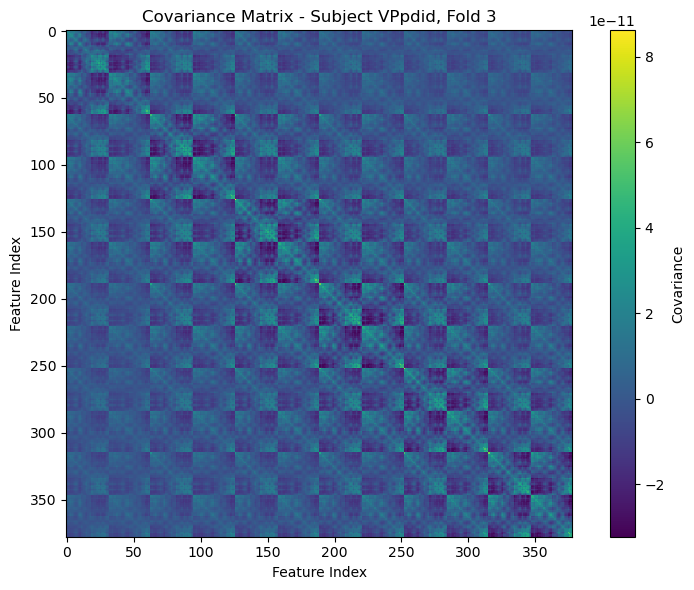

In [14]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_matrix.T, cmap='viridis', interpolation='nearest')
plt.title(f"Covariance Matrix - Subject {subject}, Fold {i_fold}")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.colorbar(label="Covariance")
plt.tight_layout()
plt.show()


In [32]:
print(X_trn_epochs.shape)

(4581, 168)
